In [ ]:
# !pip install -U scikit-learn

  Using cached scikit_learn-1.6.1-cp312-cp312-win_amd64.whl.metadata (15 kB)
  Using cached scipy-1.15.2-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached joblib-1.4.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/11.1 MB ? eta -:--:--
   ---------------------------------------- 0.1/11.1 MB 1.1 MB/s eta 0:00:11
   ---- ----------------------------------- 1.3/11.1 MB 14.1 MB/s eta 0:00:01
   ---- ----------------------------------- 1.3/11.1 MB 14.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 15.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 15.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 15.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 15.1 MB/s eta 0:00:01
   ------- -------------------------------- 2.1/11.1 MB 15.1 MB/s eta 0:00:01
   -------- ---------------


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


In [7]:
from micrograd.engine import Value
from micrograd.nn import Neuron, Layer, MLP

In [8]:
np.random.seed(1337)
random.seed(1337)

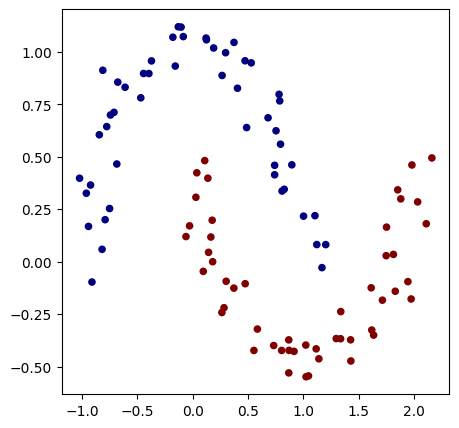

In [9]:
# make up a dataset
from sklearn.datasets import make_moons, make_blobs

X, y = make_moons(n_samples=100, noise=0.1)

y = y*2 - 1

plt.figure(figsize=(5,5))
plt.scatter(X[:, 0], X[:, 1], c=y, s=20, cmap='jet')


In [10]:
#initialize a model

model = MLP(2, [16, 16, 1]) # 2-layer neural network
print(model)
print("number of parameters", len(model.parameters()))

MLP of [Layer of [ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2), ReLUNeuron(2)], Layer of [ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16), ReLUNeuron(16)], Layer of [LinearNeuron(16)]]
number of parameters 337


In [11]:
# loss function

def loss(batch_size=None):
    #inline dataloader
    if batch_size is None:
        Xb, yb = X, y
    else:
        ri = np.random.permutation(X.shape[0][:batch_size])
        Xb, yb = X[ri], y[ri]
    
    inputs = [list(map(Value, xrow)) for xrow in Xb]

    #forward the model to get scores
    scores = list(map(model, inputs))

    # svm "max-margin" loss
    losses = [(1 + -yi*scorei).relu() for yi, scorei in zip(yb, scores)]
    data_loss = sum(losses) * (1.0 / len(losses))
    #L2 regularization
    alpha = 1e-4
    reg_loss = alpha * sum((p*p for p in model.parameters()))
    total_loss = data_loss + reg_loss

    #also get accuracy
    accuracy = [(yi > 0) == (scorei.data > 0) for yi, scorei in zip(yb, scores)]
    return total_loss, sum(accuracy)/len(accuracy)

total_loss, acc = loss()
print(total_loss, acc)


value(data=0.8958441028683222, grad=0) 0.5


step 0 loss 0.89584, accuracy 50.00%


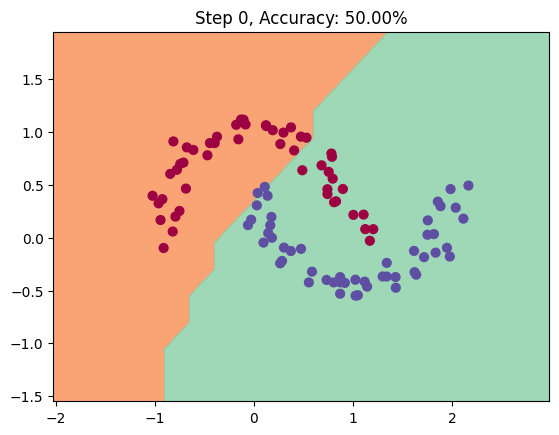

step 10 loss 0.24507, accuracy 91.00%


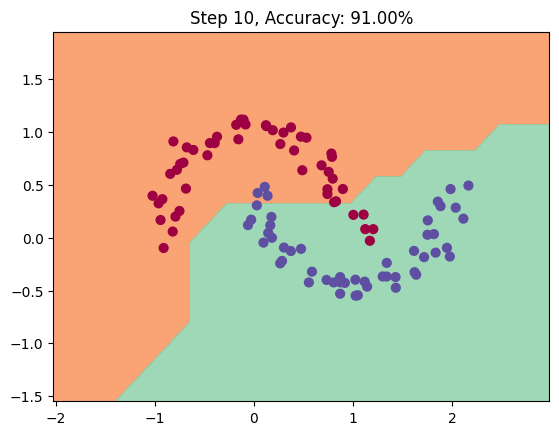

step 20 loss 0.18978, accuracy 91.00%


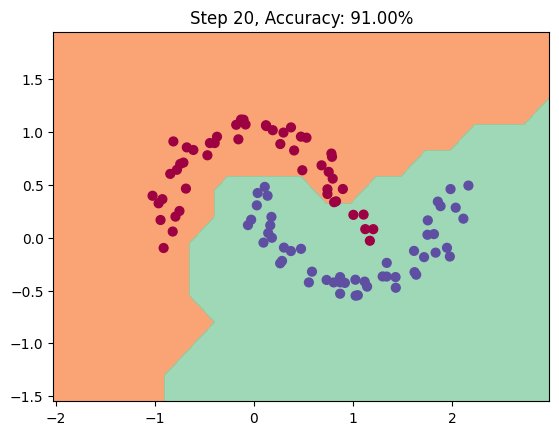

step 30 loss 0.11731, accuracy 95.00%


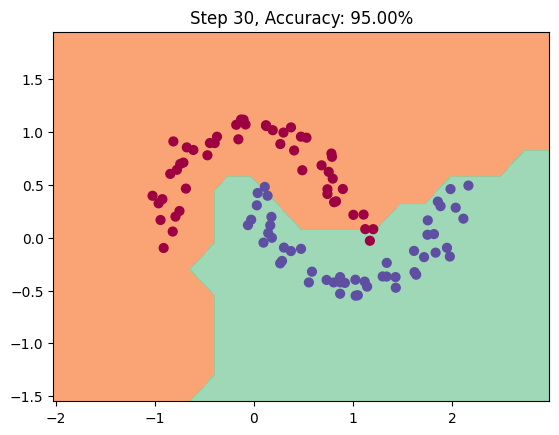

step 40 loss 0.06016, accuracy 100.00%


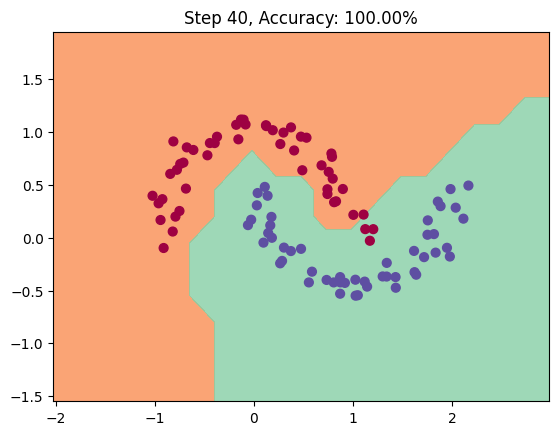

step 50 loss 0.09875, accuracy 96.00%


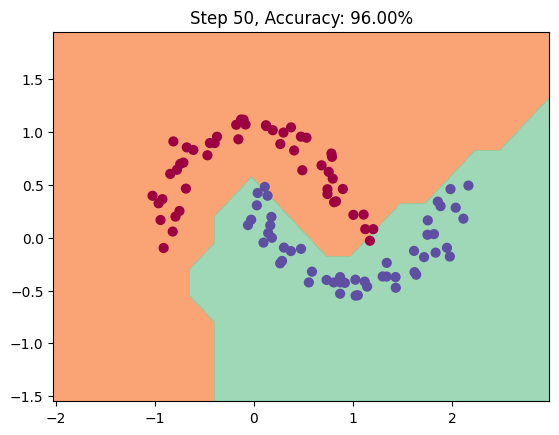

step 60 loss 0.03260, accuracy 99.00%


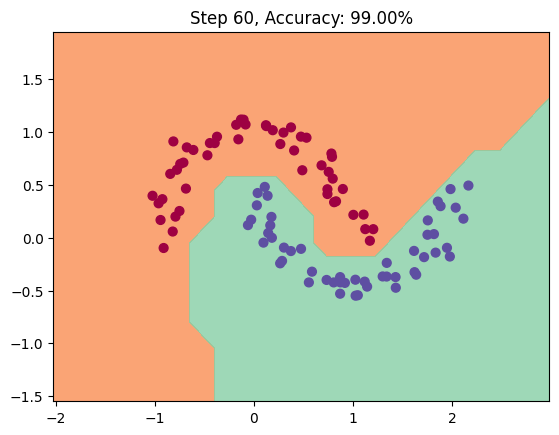

step 70 loss 0.01423, accuracy 100.00%


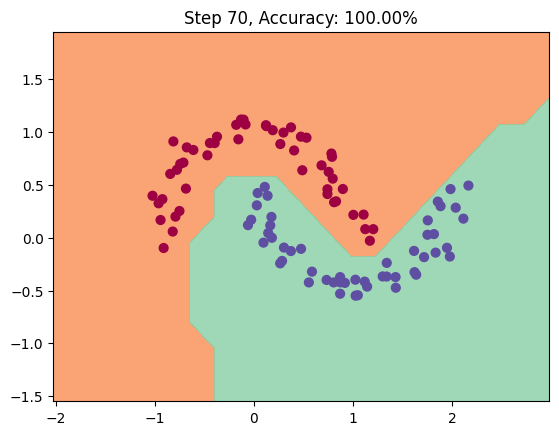

step 80 loss 0.01232, accuracy 100.00%


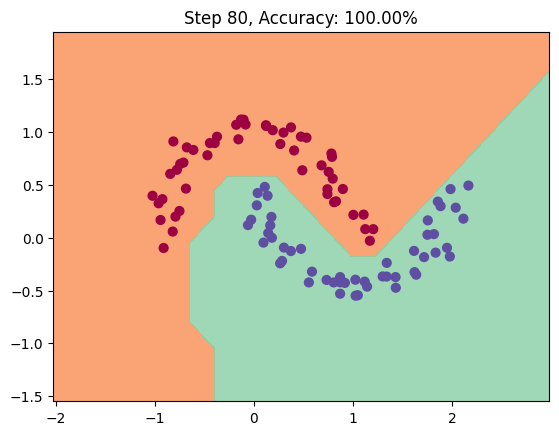

step 90 loss 0.01098, accuracy 100.00%


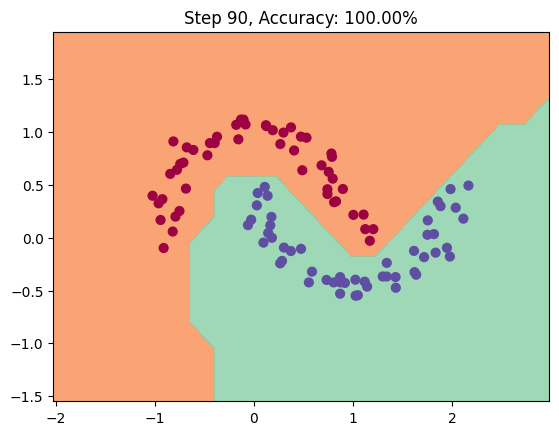

step 100 loss 0.01098, accuracy 100.00%


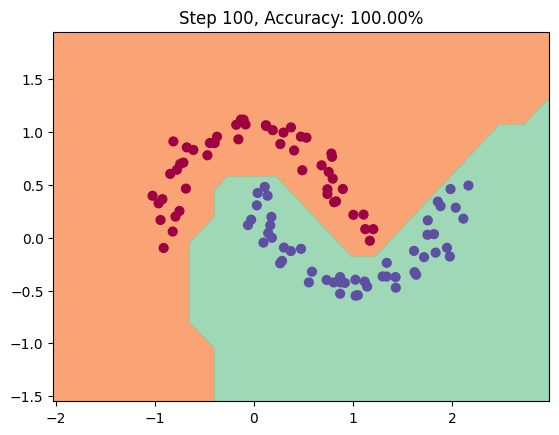

In [12]:
#Show Graph and Accuracy Scores

import matplotlib.pyplot as plt
import numpy as np

plt.ion()  # Turn on interactive mode
fig = plt.figure()

for k in range(101):
    # Forward
    total_loss, acc = loss()

    # Backward
    model.zero_grad()
    total_loss.backward()

    # Gradient descent step
    learning_rate = 1.0 - 0.9 * k / 100
    for p in model.parameters():
        p.data -= learning_rate * p.grad

    # Print progress
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data:.5f}, accuracy {acc*100:.2f}%")

        # Clear plot
        plt.clf()

        # Plot decision boundary
        h = 0.25
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                             np.arange(y_min, y_max, h))
        Xmesh = np.c_[xx.ravel(), yy.ravel()]
        inputs = [list(map(Value, xrow)) for xrow in Xmesh]
        scores = list(map(model, inputs))
        Z = np.array([s.data > 0 for s in scores])
        Z = Z.reshape(xx.shape)

        # Plot contours and data
        plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
        plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
        plt.xlim(xx.min(), xx.max())
        plt.ylim(yy.min(), yy.max())
        plt.title(f"Step {k}, Accuracy: {acc*100:.2f}%")

        plt.pause(0.1)  # Pause to update plot

plt.ioff()  # Turn off interactive mode
plt.show()

In [8]:
# optimization
for k in range(100):
    #forward 
    total_loss, acc = loss()

    #backward
    model.zero_grad()
    total_loss.backward()

    learning_rate = 1.0 - 0.9*k/100
    for p in model.parameters():
        p.data -= learning_rate * p.grad
    
    if k % 10 == 0:
        print(f"step {k} loss {total_loss.data}, accuracy {acc*100}%")



step 0 loss 0.010977452372503973, accuracy 100.0%
step 10 loss 0.010935397626771952, accuracy 100.0%
step 20 loss 0.01089742707833534, accuracy 100.0%
step 30 loss 0.010863499174139033, accuracy 100.0%
step 40 loss 0.010833576859166135, accuracy 100.0%
step 50 loss 0.01080762750897691, accuracy 100.0%
step 60 loss 0.010788007232603477, accuracy 100.0%
step 70 loss 0.013504187281113597, accuracy 100.0%
step 80 loss 0.010835580854895792, accuracy 100.0%
step 90 loss 0.010825205087826013, accuracy 100.0%


(-1.548639298268643, 1.951360701731357)

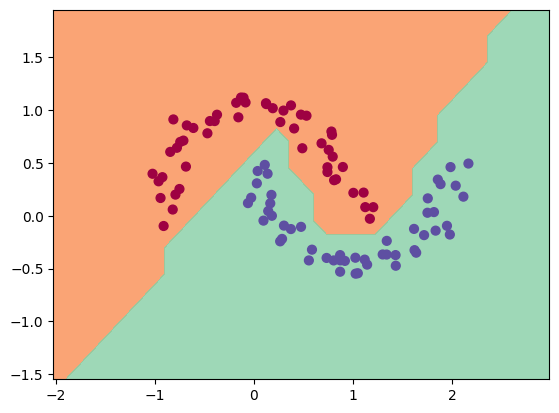

In [ ]:
# visualize decision boundary

h = 0.25
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
Xmesh = np.c_[xx.ravel(), yy.ravel()]
inputs = [list(map(Value, xrow)) for xrow in Xmesh]
scores = list(map(model, inputs))
Z = np.array([s.data > 0 for s in scores])
Z = Z.reshape(xx.shape)

fig = plt.figure()
plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())